<a href="https://colab.research.google.com/github/sooonsyk/ESAA/blob/main/%08Week5_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**06. 사이킷런으로 수행하는 타이타닉 생존자 예측**
- 캐글에서 제공하는 타이타닉 탑승자 데이터 기반으로 생존자 예측

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

titanic_df = pd.read_csv('/content/drive/MyDrive/train.csv')
titanic_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [ ]:
print('\n ### 학습 데이터 정보 ### \n')
print(titanic_df.info())


 ### 학습 데이터 정보 ### 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


- RangeIndex는 DataFrame의 인덱스의 범위를 나타내므로 전체 로우 수를 알 수 있음
- 판다스의 object타입은 string 타입으로 봐도 무방 - 판다스는 넘파이 기반으로 만들어졌고 넘파이의 String타입이 길이 제한이 있어서 이에 대한 구분을 위해 object타입으로 명기한 것
- 사이킷런 머신러닝 알고리즘은 Null 값을 허용하지 않으므로 Null 값을 어떻게 처리할지 결정해야 함

In [ ]:
titanic_df['Age'].fillna(titanic_df['Age'].mean(), inplace=True)   #Null 값 평균 나이로 변경
titanic_df['Cabin'].fillna('N', inplace=True)     #Null 값 N으로 변경
titanic_df['Embarked'].fillna('N', inplace=True)
print('데이터 세트 Null 값 개수', titanic_df.isnull().sum().sum())

데이터 세트 Null 값 개수 0


In [ ]:
# 문자열 피처 값 분류 살펴보기
print('Sex 값 분포 : \n', titanic_df['Sex'].value_counts())
print('\nCabin 값 분포 :\n', titanic_df['Cabin'].value_counts())
print('\nEmbarked 값 분포 :\n', titanic_df['Embarked'].value_counts())

Sex 값 분포 : 
 male      577
female    314
Name: Sex, dtype: int64

Cabin 값 분포 :
 N              687
C23 C25 C27      4
G6               4
B96 B98          4
C22 C26          3
              ... 
E34              1
C7               1
C54              1
E36              1
C148             1
Name: Cabin, Length: 148, dtype: int64

Embarked 값 분포 :
 S    644
C    168
Q     77
N      2
Name: Embarked, dtype: int64


In [ ]:
#Cabin의 경우 선실 번호 중 선실 등급을 나타내는 알파벳이 중요해 보임
titanic_df['Cabin'] = titanic_df['Cabin'].str[:1]
print(titanic_df['Cabin'].head(3))

0    N
1    C
2    N
Name: Cabin, dtype: object


In [ ]:
#성별이 생존 확률에 미치는 영향
titanic_df.groupby(['Sex','Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

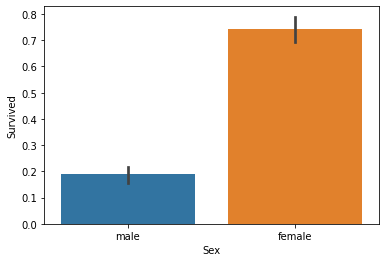

In [ ]:
sns.barplot(x='Sex', y='Survived', data=titanic_df)

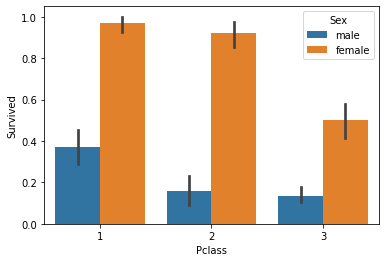

In [ ]:
#객실등급별 성별에 따른 생존 확률, 단순히 객실 등급별로 생존 확률을 보는 것보다 성별을 함께 고려해 분석하는 것이 더 효율적
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=titanic_df)

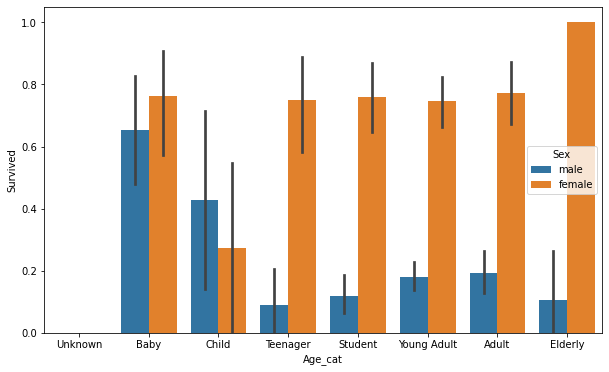

In [ ]:
#Age에 따른 생존 확률
#Age값 범위별로 분류

#입력 age에 따라 구분 값을 반환하는 함수 설정
def get_category(age):
  cat=''
  if age<= -1 : cat = 'Unknown'
  elif age<=5 : cat = 'Baby'
  elif age<=12 : cat = 'Child'
  elif age<=18 : cat = 'Teenager'
  elif age<=25 : cat = 'Student'
  elif age<=35 : cat = 'Young Adult'
  elif age<=60 : cat = 'Adult'
  else : cat = 'Elderly'

  return cat

#막대그래프의 크기 figure를 더 크게 설정
plt.figure(figsize=(10,6))    # figsize(가로길이,세로길이) 인치 단위로 그래프 크기 설정

#X축의 값을 순차적으로 표시하기 위한 설정
group_names = ['Unknown','Baby','Child','Teenager','Student','Young Adult','Adult','Elderly']

#lambda 식에 위에서 생성한 get_category()함수를 반환값으로 지정
#get_category(X)는 입력값으로 'Age' 칼럼 값을 받아서 해당하는 cat 반환
titanic_df['Age_cat'] = titanic_df['Age'].apply(lambda x: get_category(x))
sns.barplot(x='Age_cat', y='Survived', hue='Sex', data=titanic_df, order=group_names)
titanic_df.drop('Age_cat',axis=1, inplace=True)

- Sex, Age, Pclass 등이 중요하게 생존을 좌우하는 피처임

남아있는 문자열 카테고리 피처를 숫자형 카테고리 피처로 변환 - 사이킷런의 LabelEndocer 클래스 이용
  - LabelEncoder 객체는 카테고리 값의 유형 수에 따라 0~(카테고리 유형수-1)까지의 숫자 값으로 변환

In [ ]:
from sklearn import preprocessing

def encode_features(dataDF):
  features=['Cabin','Sex','Embarked']
  for feature in features:
    le = preprocessing.LabelEncoder()
    le = le.fit(dataDF[feature])
    dataDF[feature] = le.transform(dataDF[feature])

  return dataDF

titanic_df = encode_features(titanic_df)
titanic_df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,147,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,81,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,147,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,55,2
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,147,2


In [ ]:
#지금까지 피처를 가공한 내역 정리, 함수로 만들어 쉽게 재사용할 수 있게

#Null 처리 함수
def fillna(df):
  df['Age'].fillna(df['Age'].mean(),inplace=True)
  df['Cabin'].fillna('N',inplace=True)
  df['Embarked'].fillna('N',inplace=True)
  df['Fare'].fillna(0, inplace=True)
  return df

#머신러닝 알고리즘에 불필요한 속성제거
def drop_features(df):
  df.drop(['PassengerId','Name','Ticket'],axis=1, inplace=True)
  return df

#레이블 인코딩 수행
def format_features(df):
  df['Cabin'] = df['Cabin'].str[:1]
  features = ['Cabin','Sex','Embarked']
  for feature in features:
    le = preprocessing.LabelEncoder()
    le = le.fit(df[feature])
    df[feature] = le.transform(df[feature])
  return df

#앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
  df = fillna(df)
  df = drop_features(df)
  df = format_features(df)
  return df

In [ ]:
#원본 데이터 재로딩하고, 피처 데이터 세트와 레이블 데이터 세트 추출
titanic_df = pd.read_csv('/content/drive/MyDrive/train.csv')
y_titanic_df = titanic_df['Survived']  #클래스 결정값 데이터 세트로 만듦
X_titanic_df = titanic_df.drop('Survived', axis=1) #피처 데이터 세트 만듦

X_titanic_df = transform_features(X_titanic_df) #피처 데이터 세트 가공

In [ ]:
#내려받은 학습 데이터 세트를 기반으로 해서 train_test_split() 를 이용해 별도의 테스트 데이터 세트 추출
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=11)

- 사이킷런은 결정 트리를 위해서 DecisionTreeClassifier, 랜덤 포레스트를 위해 RandomForestClassifier, 로지스틱 회귀를 위해 LogisticRegression 클래스를 제공

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#결정트리, Random Forest, 로지스틱 회귀를 위한 사이킷런 Classifier 클래스 생성
dt_clf = DecisionTreeClassifier(random_state=11)
rf_clf = RandomForestClassifier(random_state=11)
lr_clf = LogisticRegression()

#DecisionTreeClassifier 학습/예측/평가
dt_clf.fit(X_train,y_train)
dt_pred = dt_clf.predict(X_test)
print('DecisionTreeClassifier 정확도 : {0:.4f}'.format(accuracy_score(y_test, dt_pred)))

#RandomForestClassifier 학습/예측/평가
rf_clf.fit(X_train,y_train)
rf_pred = rf_clf.predict(X_test)
print('RandomForestClassifier 정확도 : {0:.4f}'.format(accuracy_score(y_test, rf_pred)))

#LogisticRegression 학습/예측/평가
lr_clf.fit(X_train,y_train)
lr_pred = lr_clf.predict(X_test)
print('LogisticRegression 정확도: {0:.4f}'.format(accuracy_score(y_test, lr_pred)))

DecisionTreeClassifier 정확도 : 0.7877
RandomForestClassifier 정확도 : 0.8547
LogisticRegression 정확도: 0.8492


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


- 3개의 알고리즘 중 LogisticRegression이 타 알고리즘에 비해 높은 정확도 나타냄, 아직 최적화 작업을 수행하지 않았고, 데이터 양도 충분하지 않기 때문에 어떤 알고리즘이 가장 성능이 좋다고 평가할 수 없음

In [ ]:
#교차검증으로 결정 트리 모델 평가
from sklearn.model_selection import KFold

def exec_kfold(clf, folds=5):
  #폴드 세트 5개인 KFold객체 생성, 폴드 수만큼 예측 결과 저장을 위한 리스트 객체 생성
  kfold = KFold(n_splits=folds)
  scores=[]

  #KFold 교차 검증 수행
  for iter_count, (train_index, test_index) in enumerate(kfold.split(X_titanic_df)):   #enumerate() 함수는 기본적으로 인덱스와 원소로 이루어진 튜플(tuple)을 만들어줌
    #X_titanic_df 데이터에서 교차 검증별로 학습과 검증 데이터를 가리키는 index 생성
    X_train, X_test = X_titanic_df.values[train_index], X_titanic_df.values[test_index]
    y_train, y_test = y_titanic_df.values[train_index], y_titanic_df.values[test_index]
    #Classifier 학습, 예측, 정확도 계산
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    scores.append(accuracy)
    print('교차 검증 {0} 정확도 : {1:.4f}'.format(iter_count, accuracy))

  #5개 fold에서의 평균 정확도 계산
  mean_score = np.mean(scores)
  print('평균 정확도 : {0:.4f}'.format(mean_score))

#exec_kfold 호출
exec_kfold(dt_clf, folds=5)

교차 검증 0 정확도 : 0.7542
교차 검증 1 정확도 : 0.7809
교차 검증 2 정확도 : 0.7865
교차 검증 3 정확도 : 0.7697
교차 검증 4 정확도 : 0.8202
평균 정확도 : 0.7823


In [ ]:
#교차 검증 cross_val_score() 이용해서 수행
from sklearn.model_selection import cross_val_score

scores = cross_val_score(dt_clf, X_titanic_df, y_titanic_df, cv=5)
for iter_count, accuracy in enumerate(scores):
  print('교차 검증 {0} 정확도 : {1:.4f}'.format(iter_count, accuracy))

print('평균 정확도 : {0:.4f}'.format(np.mean(scores)))

교차 검증 0 정확도 : 0.7430
교차 검증 1 정확도 : 0.7753
교차 검증 2 정확도 : 0.7921
교차 검증 3 정확도 : 0.7865
교차 검증 4 정확도 : 0.8427
평균 정확도 : 0.7879


- 두 평균 정확도가 다른 이유는 cross_val_score()는 StratifiedKFold를 이용해 폴드 세트를 분할하기 때문

In [ ]:
#GridSearchCV 를 이용해 DecisionTreeClassifier의 최적 하이퍼 파라미터를 찾고 예측성능 측정
#CV는 5개의 폴드세트 지정하고 하이퍼 파라미터는 max_depth, min_samples_split, min_samples_leaf를 변경하면서 성능 측정

from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':[2,3,5,10],
              'min_samples_split':[2,3,5],
              'min_samples_leaf':[1,5,8]}

grid_dclf = GridSearchCV(dt_clf, param_grid=parameters, scoring='accuracy', cv=5)
grid_dclf.fit(X_train, y_train)

print('GridSearchCV 최적 하이퍼 파라미터 :', grid_dclf.best_params_)
print('GridSearchCV 최고 정확도 :{0:.4f}'.format(grid_dclf.best_score_))
best_dclf = grid_dclf.best_estimator_

#GridSearchCV의 최적 하이퍼 파라미터로 학습된 Estimator로 예측 및 평가 수행
dpredictions = best_dclf.predict(X_test)
accuracy = accuracy_score(y_test, dpredictions)
print('테스트 세트에서의 DecisionTreeClassifier 정확도 :{0:.4f}'.format(accuracy) )

GridSearchCV 최적 하이퍼 파라미터 : {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
GridSearchCV 최고 정확도 :0.7992
테스트 세트에서의 DecisionTreeClassifier 정확도 :0.8715


- 예측 정확도 향상됨

###하이퍼 파라미터
- estimator(string) : classifier, regressor, pipeline

- param_grid(dict) : 사용될 파라미터명, 값 을 dict 형태로
  - max_depth : 트리의 최대 깊이 (값이 클수록 모델의 복잡도가 올라간다.)
  - min_samples_split : 자식 노드를 분할하는데 필요한 최소 샘플 수 (default : 2)
  - min_samples_leaf : 리프 노드에 있어야 할 최소 샘플 수 (default : 1)

- scoring(string) : 예측 성능을 측정할 평가 방법 지정

- cv(int) : 교차 검증을 위하 분할되는 학습/테스트 세트의 개수 지정

- refit(bool) : true인 경우 최적의 하이퍼 파라미터를 찾은 후 입력된 개체를 해당 하이퍼 파라미터로 재학습